## CCS - final project - Jona Kao, Niclas Leinen
##### This jupyter notebook contains code for three different models. Use the following links to quickly get to the code of the different models and other sections of the code!

<b>[Libraries](#libraries)</b> \
<b>[Data Import](#data-import)</b> \
<b>[k and $\beta$](#k-and-beta-values)</b> \
<b>[Model 1: Ex-Gaussian model](#model-1-ex-gaussian)</b> \
<b>[Model 2: LBA model](#model-2-lba)</b> \
<b>[Model 3: Log normal model](#model-3-log-normal)</b>

# Libraries
---

In [1]:
import scipy
from scipy.optimize import minimize
from scipy.stats import exponnorm
from scipy.stats import ks_1samp
from scipy.stats import ks_2samp
from scipy.stats import norm
from scipy import stats
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

---
# Settings
---

This section contains some settings like setting the seed, paths and controlling whether to save generate figures or not.

In [104]:
np.random.seed(42)
exponnorm.random_state = 42

SAVE_FIGURES = True

PATH_TO_MAT_FILES = "Data/"
PATH_TO_PLOTS_REACTION_TIME = "Plots/Reaction_times/"
PATH_TO_PLOTS_MODEL_1 = "Plots/Model_1/"
PATH_TO_PLOTS_MODEL_2 = "Plots/Model_2/"
PATH_TO_PLOTS_MODEL_3 = "Plots/Model_3/"

---
# Data import
---

We first define the path to the folder containing the sample data.

In [3]:
mat_files = [f for f in os.listdir(PATH_TO_MAT_FILES) if f.endswith(".mat")]

Then we create a function that loads and extracts the contents of a .mat-file.

In [4]:
def load_mat_file(file_path):
    mat_data = scipy.io.loadmat(file_path)

    # Extract data and convert to DataFrames
    data_train = pd.DataFrame(mat_data['data_train'])
    data_test = pd.DataFrame(mat_data['data_test'])
    data_labels = [label[0] for label in mat_data['data_labels'][0]]  # Convert to list of column names

    # Assign column names
    data_train.columns = data_labels
    data_test.columns = data_labels

    return data_train, data_test

Now we can load all the data into two dictionaries: <i>TRAIN_DATA</i> and <i>TEST_DATA</i>.

In [5]:
TRAIN_DATA = {}
TEST_DATA = {}

for mat_file in mat_files:
    filepath = os.path.join(PATH_TO_MAT_FILES, mat_file)
    train, test = load_mat_file(filepath)
    
    # Store using participant ID (file name without .mat)
    participant_id = mat_file.replace(".mat", "")
    TRAIN_DATA[participant_id] = train
    TEST_DATA[participant_id] = test

We need to filter the data with a missing action value.

In [6]:
train_data_with_filtered_actions = {}
test_data_with_filtered_actions = {}

for participant_id, data in TRAIN_DATA.items():
    # Filter out rows where the action column has a value of 0
    filtered_data = data[data["action (1=immediate, 2=delayed, 0=missing)"] != 0]
    filtered_data = filtered_data.reset_index(drop=True)
    
    train_data_with_filtered_actions[participant_id] = filtered_data

for participant_id, data in TEST_DATA.items():
    # Filter out rows where the action column has a value of 0
    filtered_data = data[data["action (1=immediate, 2=delayed, 0=missing)"] != 0]
    filtered_data = filtered_data.reset_index(drop=True)
    
    test_data_with_filtered_actions[participant_id] = filtered_data

# Replace the original dictionaries with the filtered ones
TRAIN_DATA = train_data_with_filtered_actions
TEST_DATA = test_data_with_filtered_actions

We will then define the labels of the data table for easier future use.

In [7]:
LABEL_IMM_OUT = "immOutcome"
LABEL_DEL_OUT = "delOutcome"
LABEL_DELAY = "delay"
LABEL_CHOICE = "action (1=immediate, 2=delayed, 0=missing)"
LABEL_P_IMM = "p_imm"
LABEL_RT = "RT"

The data is now fully loaded into <i>TRAIN_DATA</i> and <i>TEST_DATA</i> with the following layout: \
<i>data_set</i>[x] = data from participant x.

We will be using these datasets for all of our models.

### First look at the data

To get a general idea of how the reaction times are distributed among participants, we can create some plots to analyze their behaviour. \
We first need to extract the reaction times from the data:

In [8]:
def get_reaction_times(data_set):
    reaction_times = []
    
    # Get reaction times from each participant in the training data
    for participant in data_set:
        data_matrix = TRAIN_DATA[participant]
        reaction_times.append((data_matrix[LABEL_RT]))
    
    return reaction_times

Then we can make a plot of the overall reaction time distribution:

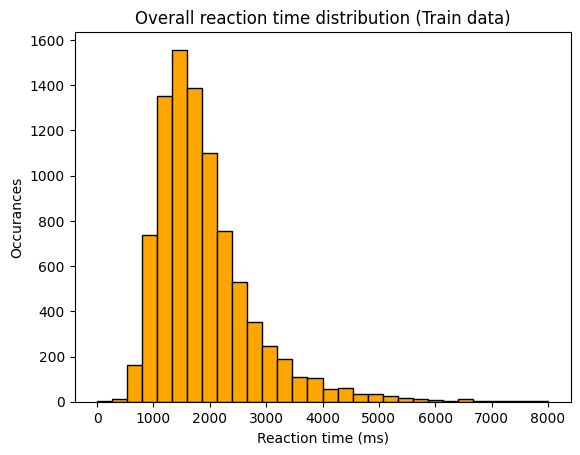

In [112]:
all_reaction_times = get_reaction_times(TRAIN_DATA)

all_reaction_times_flattened = []

for i in range(len(all_reaction_times)):
    for rt in all_reaction_times[i]:
        all_reaction_times_flattened.append(rt)
    

plt.hist(all_reaction_times_flattened, bins=30, range=(0, 8000), color="orange", edgecolor="black")
plt.xlabel("Reaction time (ms)")
plt.ylabel("Occurances")
plt.title("Overall reaction time distribution (Train data)")

if SAVE_FIGURES:
    plot_filename = os.path.join(PATH_TO_PLOTS_REACTION_TIME, "overall_reaction_times")
    plt.savefig(plot_filename)

plt.show()

Another data point that might be interesting to look at is the correlation between reaction times and the choices made:

C:\Users\Nicla\AppData\Local\Temp\ipykernel_21452\1324050405.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([abs(int(tick)) for tick in ax.get_yticks()])


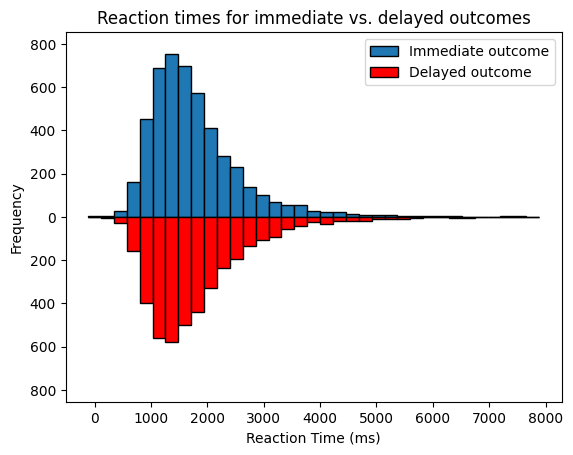

In [111]:
all_reaction_times_immediate_outcome = []
all_reaction_times_delayed_outcome = []

for i, participant in enumerate(TRAIN_DATA):
    rts = TRAIN_DATA[participant][LABEL_RT]
    choices = TRAIN_DATA[participant][LABEL_CHOICE]
    
    for j in range(len(rts)):
        if choices[j] == 0:
            continue
        elif choices[j] == 1:
            all_reaction_times_immediate_outcome.append(rts[j])
        else:
            all_reaction_times_delayed_outcome.append(rts[j])


fig, ax = plt.subplots()

counts_immediate, bins_immediate = np.histogram(all_reaction_times_immediate_outcome, bins=35, range=(0, 8000))
counts_delayed, bins_delayed = np.histogram(all_reaction_times_delayed_outcome, bins=35, range=(0, 8000))

ax.bar(bins_delayed[:-1], counts_immediate, width=np.diff(bins_immediate), alpha=1, edgecolor="black", label="Immediate outcome")
ax.bar(bins_delayed[:-1], -counts_delayed, width=np.diff(bins_delayed), color="red", alpha=1, edgecolor="black", label="Delayed outcome")

ax.legend()
ax.set_xlabel('Reaction Time (ms)')
ax.set_ylabel('Frequency')
ax.set_title("Reaction times for immediate vs. delayed outcomes")

max_count = max(max(counts_immediate), max(counts_delayed))
ax.set_ylim(-max_count - 100, max_count + 100)
ax.set_yticklabels([abs(int(tick)) for tick in ax.get_yticks()])

if SAVE_FIGURES:
    plot_filename = os.path.join(PATH_TO_PLOTS_REACTION_TIME, "reaction_times_delayed_vs_immediate")
    plt.savefig(plot_filename)

plt.show()

---
# Figuring out values for $k$ and $\beta$
---

We will need the following formulas in order to calculate our values for $k$ and $\beta$:

(1) $SV_{delayed,i}$ = $\frac{delayed\_outcome}{1+k*delay}$

(2) $p_{delayed,i}$ = $\frac{1}{1+e^{-\beta(sv_{delayed} - sv_{immediate})}}$

(3) $log_L$ = $\sum_{i = 1}^n c_i log(p_{delayed,i}) + (1 - c_i) log(1-p_{delayed,i})$

Therefore, we will need to make some intital estimates for $k$ and $\beta$.
In this case, we chose random values using the random library, and we got the values $k = 0.000237$ and $\beta = 4.423591$

In [ ]:
INITIAL_k = 0.000237
INITIAL_beta = 4.423591

We have to define the behaviour of the model when dealing with sample entries that are missing an <i>action</i>-value. (<i>action</i> = 0).
<ul>
    <li>Option 1: Set value to an <b>immediate</b> response.</li>
    <li>Option 2: Set value to a <b>delayed</b> response.</li>
    <li>Option 3: Set value to a <b>random</b> response.</li>
    <li>Option 4: <b>Ignore</b> entries with missing <i>action</i>-value</li>
</ul>

For our very first attempts at building the models we used option 1 but we decided to switch to option 4 in the end, as we thought said values might contaminate the final results of the models.

In [ ]:
# Helper function to clamp action values between 0 and 1.
# Remaps action values of 2.0 to 1.0 (delayed) and all other values to 0.0 (immediate).
# This also covers the case of missing action values, which are treated as immediate.
def action_values_clamp01(actions):
    clamped_actions = []
    
    for action in actions:
        if action == 2.0:
            clamped_actions.append(1.0)
        else:
            clamped_actions.append(0.0)
    
    return clamped_actions

#### $k$-log-likelihood-function

In [ ]:
def log_likelihood_k(k, data_set, participant):
    beta = INITIAL_beta
    log_L = 0

    data_matrix = data_set[participant]
    
    sample_size = len(data_matrix)
    
    sv_immediates = data_matrix[LABEL_IMM_OUT]
    
    delayed_outcomes = data_matrix[LABEL_DEL_OUT]
    delays = data_matrix[LABEL_DELAY]
    actions = data_matrix[LABEL_CHOICE]
    
    clamped_actions = action_values_clamp01(actions)
    
    
    for i in range(sample_size):
        sv_delayed = delayed_outcomes[i] / (1.0 + k * max(delays[i], 1e-10))
        
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        log_L += clamped_actions[i] * np.log(p_delayed) + (1.0 - clamped_actions[i]) * np.log(1.0 - p_delayed)

    return -log_L

Minimize $k$ values with this function:

In [ ]:
results_k = []

for participant in TRAIN_DATA:
    result = minimize(log_likelihood_k, INITIAL_k, args=(TRAIN_DATA, participant))
    results_k.append(result.x)

#### $\beta$-log-likelihood-function using calculated $k$-values <a id="m1_beta_llf"></a>

In [ ]:
def log_likelihood_beta(beta, data_set, participant, participant_id):
    # Retrieve the k value for the current participant
    k = results_k[participant_id]
    log_L = 0

    # Get the data matrix for the current participant
    data_matrix = data_set[participant]
    
    # Determine the sample size
    sample_size = len(data_matrix)
    
    # Extract relevant columns from the data matrix
    sv_immediates = data_matrix[LABEL_IMM_OUT]
    delayed_outcomes = data_matrix[LABEL_DEL_OUT]
    delays = data_matrix[LABEL_DELAY]
    actions = data_matrix[LABEL_CHOICE]
    
    # Clamp action values to be between 0 and 1
    clamped_actions = action_values_clamp01(actions)

    # Loop through each sample in the data matrix
    for i in range(sample_size):
        # Calculate the subjective value of the delayed outcome
        sv_delayed = delayed_outcomes[i] / (1.0 + k * max(delays[i], 1e-10))
        
        # Calculate the probability of choosing the delayed outcome
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        # Update the log likelihood
        log_L += clamped_actions[i] * np.log(p_delayed) + (1.0 - clamped_actions[i]) * np.log(1.0 - p_delayed)


    return -log_L

Minimize $\beta$ with this function:

In [ ]:
# Initialize an empty list to store beta results
results_beta = []

for i, participant in enumerate(TRAIN_DATA):
    # Minimize the log likelihood function to find the best beta value
    result = minimize(log_likelihood_beta, INITIAL_beta, args=(TRAIN_DATA, participant, i))
    results_beta.append(result.x)

We now have $k$ and $\beta$ values that we can universally use for all models.

---
# Accuracy test
---

We define a function that predicts choices given the $k$ and $\beta$ of the participant. \
The model will predict the action to be <i>immediate</i> if $p \leq 0.5$, else <i>delayed</i>.

In [ ]:
def predict_choices(k, beta, participant):
    data_matrix = TEST_DATA[participant]

    sv_immediates = data_matrix[LABEL_IMM_OUT]
    delayed_outcomes = data_matrix[LABEL_DEL_OUT]
    delays = data_matrix[LABEL_DELAY]

    sample_size = len(data_matrix)
    
    predicted_choices = []
    
    # Loop through each sample in the data matrix
    for i in range(sample_size):
        # Calculate the subjective value of the delayed outcome
        sv_delayed = delayed_outcomes[i] / (1.0 + k * max(delays[i], 1e-10))
        
        # Calculate the probability of choosing the delayed outcome
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        if p_delayed > 0.5:
            predicted_choices.append(1)
        else:
            predicted_choices.append(0)
    
    return predicted_choices

We further define a function that calculates the prediction accuries by comparing the predictions to the actual choices made in the test-dataset. The output ranges from 0-100 (percentage).

In [ ]:
def predict_accuracies(k, beta, participant):
    predicted_choices = predict_choices(k, beta, participant)
    
    actions = TEST_DATA[participant][LABEL_CHOICE]
    
    sample_size = len(actions)
    
    clamped_actions = action_values_clamp01(actions)

    correct_guesses = 0
    
    for i in range(sample_size):
        if clamped_actions[i] == predicted_choices[i]:
            correct_guesses += 1
    
    return correct_guesses / sample_size * 100

Now we can test the accuracies we would get when using the $k$ and $\beta$ values we calculated above only (meaning no model). 

In [ ]:
PREDICTION_ACCURACIES_k_beta = []

for i, participant in enumerate(TEST_DATA):
    accuracy_score = predict_accuracies(results_k[i], results_beta[i], participant)
    PREDICTION_ACCURACIES_k_beta.append(accuracy_score)
    
print(np.mean(PREDICTION_ACCURACIES_k_beta))

plt.hist(PREDICTION_ACCURACIES_k_beta, bins=10, range=(0, 100), color="lightgreen", edgecolor="black")
plt.title("Accuracies for each participant")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.show()

We can now get started with our first model.

---
# Model 1: Ex-Gaussian
---

Fit an Ex-Gaussian distribution to the reaction time data using scipy.exponnorm

In [ ]:
TRAIN_RTs = get_reaction_times(TRAIN_DATA)

ex_gaussian_fits = []

for rt in TRAIN_RTs:
    ex_gaussian_fits.append(exponnorm.fit(rt))

n = len(ex_gaussian_fits)

# Extracting the parameters
K_values = [ex_gaussian_fits[i][0] for i in range(n)]
loc_values = [ex_gaussian_fits[i][1] for i in range(n)]
scale_values = [ex_gaussian_fits[i][2] for i in range(n)]

tau_values = [K_values[i] * scale_values[i] for i in range(n)]
mu_values = loc_values
sigma_values = scale_values

### Testing the null hypothesis

In [ ]:

# Initialize lists to store fitted CDFs, KS statistics, and p-values
fitted_cdfs = []
ks_stats = []
p_values = []

# Loop through each set of K, mu, and sigma values
for i in range(len(K_values)):
    # Create a lambda function for the fitted CDF using the exponentially modified normal distribution
    fitted_cdfs.append(lambda x: exponnorm.cdf(x, K_values[i], loc=mu_values[i], scale=sigma_values[i]))
    
    # Perform the Kolmogorov-Smirnov test for goodness of fit
    ks_stat, p_value = ks_1samp(TRAIN_RTs[i], fitted_cdfs[i])
    
    # Append the KS statistic and p-value to their respective lists
    ks_stats.append(ks_stat)
    p_values.append(p_value)


i = 0

for p_value in p_values:
    # Check if the p-value is less than 0.05 (significance level)
    if p_value < 0.05:
        print(f"Reject null hypothesis for participant with id {i}: {p_value:.4f}")

    i += 1

print(np.mean(p_values))
print(min(p_values))

# [DEBUG] Print the mean of all p-values
# print(f"Mean of all p_values: {np.mean(p_values):.4f}")

The null hyptothesis test demonstrates that the model holds true for all participants except for participant <b>#57</b>. \
The mean <i>p_value</i> lies at 0.7738. \
For every single other participant, the <i>p_value</i> is much greater than 0.05, meaning that there is an extremely small to no difference between our data and the ex-gaussian distribution. Therefore, we are going to use this approach to build our bimodal model.

## Creating a unified log-likelihood function

We first need to define the Ex-Gaussian-likelihood function:

In [ ]:
def ex_gaussian_likelihood(participant_reaction_times, K_value, mu_value, sigma_value):
    return exponnorm.logpdf(participant_reaction_times, K_value, loc=mu_value, scale=sigma_value)

The joint-log-likelihood can be calculated by the expression  $$log_{L,i}(joint)=log_{L,i}(p_{delay, i}) + log_{L,i}(reactiontime_i)$$

In [ ]:
def joint_log_likelihood_train(params, data_set, participant, i):
    log_L = 0
    mu, sigma, K, beta, k = params
    
    # Initialize the log likelihood for the current participant
    Log_L_p_delay = 0
    log_L_rt = 0
    
    data_matrix = data_set[participant]
    
    sample_size = len(data_matrix)
    
    sv_immediates = data_matrix[LABEL_IMM_OUT]
    delayed_outcomes = data_matrix[LABEL_DEL_OUT]
    delays = data_matrix[LABEL_DELAY]
    actions = data_matrix[LABEL_CHOICE]
    
    # Clamp action values to be between 0 and 1
    clamped_actions = action_values_clamp01(actions)
    
    for j in range(sample_size):
        reaction_time_likelihood = ex_gaussian_likelihood(TRAIN_RTs[i][j], K, mu, sigma)

        log_L_rt += reaction_time_likelihood
        
        # Calculate the subjective value of the delayed outcome
        sv_delayed = delayed_outcomes[j] / (1.0 + k * max(delays[j], 1e-10))
        
        # Calculate the probability of choosing the delayed outcome
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[j])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        # Update the log likelihood for the current participant
        Log_L_p_delay += clamped_actions[j] * np.log(p_delayed) + (1.0 - clamped_actions[j]) * np.log(1.0 - p_delayed)
    
    # Update the overall log likelihood
    log_L += Log_L_p_delay
    log_L += log_L_rt
    
    return -log_L

With this function we can now optimize $\mu$, $\sigma$, $K$, $\beta$ and $k$.

In [ ]:
# Initialize index and results list
results_model_1 = []

# Loop through each participant in the training data
for i, participant in enumerate(TRAIN_DATA):
    
    # Extract the initial parameters for the current participant
    # initial params seemed buggy, potential fix:
    initial_params = [
        np.ravel(mu_values[i])[0],
        np.ravel(sigma_values[i])[0],
        np.ravel(K_values[i])[0],
        np.ravel(results_beta[i])[0],
        np.ravel(results_k[i])[0]
    ]
    
    BOUNDS_MODEL_1 = [
        (None, None),
        (None, None),
        (None, None),
        (0.1, 10),
        (1e-6, 1)
    ]
    
    # Convert the initial parameters to np.array
    initial_params = np.array(initial_params)
    
    # Minimizing
    result = minimize(joint_log_likelihood_train, initial_params, args=(TRAIN_DATA, participant, i), bounds=BOUNDS_MODEL_1)
    results_model_1.append(result.x)

Now let's look at the results:

In [ ]:
for result in results_model_1:
    print(f"mu_value = {result[0]}")
    print(f"sigma_value = {result[1]}")
    print(f"K_value = {result[2]}")
    print(f"beta_result = {result[3]}")
    print(f"k_result = {result[4]}")
    print("--------------------------------")

---

# Testing Model 1

---

In [ ]:
def joint_log_likelihood_test(participant, i):
    log_L = 0
    beta = results_model_1[i][3]
    k = results_model_1[i][4]
    
    # Initialize the log likelihood for the current participant
    Log_L_p_delay = 0
    log_L_rt = 0
    
    # Get the data matrix for the current participant
    data_matrix = TEST_DATA[participant]
    # Determine the sample size
    sample_size = len(data_matrix)
    # Extract relevant columns from the data matrix
    
    sv_immediates = data_matrix[LABEL_IMM_OUT]
    delayed_outcomes = data_matrix[LABEL_DEL_OUT]
    delays = data_matrix[LABEL_DELAY]
    actions = data_matrix[LABEL_CHOICE]
    reaction_times = data_matrix[LABEL_RT]
    
    # Clamp action values to be between 0 and 1
    clamped_actions = action_values_clamp01(actions)
    
    # Loop through each sample in the data matrix
    for j in range(sample_size):
        reaction_time_likelihood = ex_gaussian_likelihood(reaction_times[j], results_model_1[i][2], results_model_1[i][0], results_model_1[i][1])
        log_L_rt += reaction_time_likelihood
        
        # Calculate the subjective value of the delayed outcome
        sv_delayed = delayed_outcomes[j] / (1.0 + k * max(delays[j], 1e-10))
        
        # Calculate the probability of choosing the delayed outcome
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[j])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        # Update the log likelihood for the current participant
        Log_L_p_delay += clamped_actions[j] * np.log(p_delayed) + (1.0 - clamped_actions[j]) * np.log(1.0 - p_delayed)
    
    # Update the overall log likelihood
    log_L += Log_L_p_delay
    log_L += log_L_rt
    
    return -log_L

In [ ]:
test_results_model_1 = []

# Loop through each participant in the training data
for i, participant in enumerate(TEST_DATA):
    # Calculate the joint log likelihood with the trained values
    result = joint_log_likelihood_test(participant, i)
    
    # Append the result to the results list
    test_results_model_1.append(result)

### AIC & BIC test

In [ ]:
def compute_aic_bic(log_likelihood, num_params, num_trials):
    AIC = 2 * num_params - 2 * log_likelihood
    BIC = num_params * np.log(num_trials) - 2 * log_likelihood
    
    return AIC, BIC


aics_model_1 = []
bics_model_1 = []

for i, participant in enumerate(TRAIN_DATA):
    params = results_model_1[i]
    
    joint_log_likelihood_model_1 = joint_log_likelihood_train(params, TRAIN_DATA, participant, i)
    num_trials = len(TRAIN_DATA[participant])
    
    aic, bic = compute_aic_bic(-joint_log_likelihood_model_1, len(params), num_trials)
    
    aics_model_1.append(aic)
    bics_model_1.append(bic)

print(np.mean(aics_model_1))
print(np.mean(bics_model_1))


### KS test

In [ ]:
TEST_RTs = get_reaction_times(TEST_DATA)

p_values_model_1 = []

output_dir = "Plots/Model_1/QQ/"
os.makedirs(output_dir, exist_ok=True)

for i, participant in enumerate(TEST_DATA):
    predicted_reaction_times = exponnorm.rvs(results_model_1[i][2], results_model_1[i][0], results_model_1[i][1], size=len(TEST_DATA[participant]))
    
    ks_stat, p_value = ks_2samp(predicted_reaction_times, TEST_RTs[i])
    
    if p_value < 0.05:
        print(f"Reject null hypothesis for participant with id {i}: {p_value:.4f}")
    
    p_values_model_1.append(p_value)

    stats.probplot(TEST_RTs[i], dist=exponnorm, sparams=(results_model_1[i][2], results_model_1[i][0], results_model_1[i][1]), plot=plt)
    plt.title(f"Q-Q Plot: Observed RTs vs. Predicted RTs (Ex-Gaussian, Participant {i})")
    
    plt.legend(["Observed RTs", "Predicted RTs"])
    
    #if SAVE_FIGURES:
    #    plot_filename = os.path.join(output_dir, f"qq_plot_participant_{i}.png")
    #    plt.savefig(plot_filename)
    
    plt.show()


print(np.mean(p_values_model_1))
print(np.min(p_values_model_1))

### Accuracy test

To test overall accuracy, we will define a function that simulates always picking <i>the same option</i>.

In [ ]:
def fixed_choice_accuracy(participant, option):
    correct_guesses = 0
    
    actions = TEST_DATA[participant][LABEL_CHOICE]
    
    clamped_actions = action_values_clamp01(actions)
    
    for i in range(len(clamped_actions)):
        if clamped_actions[i] == option:
            correct_guesses += 1
    
    return correct_guesses / len(clamped_actions) * 100

We will compute these fixed-choice accuracies <b>once</b> and reuse them for each model.

In [ ]:
prediction_accuracies_model_1 = []

ACCURACY_SCORES_FIXED_CHOICE_IMMEDIATE = []
ACCURACY_SCORES_FIXED_CHOICE_DELAYED = []


for i, participant in enumerate(TEST_DATA):
    accuracy_score = predict_accuracies(results_model_1[i][4], results_model_1[i][3], participant)
    prediction_accuracies_model_1.append(accuracy_score)

    # These are the values that are only computed once.
    # They don't change per model.
    accuracy_score_always_immediate = fixed_choice_accuracy(participant, 0)
    accuracy_score_always_delayed = 100 - accuracy_score_always_immediate
    
    ACCURACY_SCORES_FIXED_CHOICE_IMMEDIATE.append(accuracy_score_always_immediate)
    ACCURACY_SCORES_FIXED_CHOICE_DELAYED.append(accuracy_score_always_delayed)

print(f"Our model precision: {np.mean(prediction_accuracies_model_1):.2f}%")
print(f"Always choosing \"immediate\": {np.mean(ACCURACY_SCORES_FIXED_CHOICE_IMMEDIATE):.2f}%")
print(f"Always choosing \"delayed\": {np.mean(ACCURACY_SCORES_FIXED_CHOICE_DELAYED):.2f}%")

plt.hist(PREDICTION_ACCURACIES_k_beta, bins=10, range=(0, 100), color="lightgreen", edgecolor="black")
plt.title("Accuracies for each participant (pure choice)")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.show()

plt.hist(prediction_accuracies_model_1, bins=10, range=(0, 100), color="red", edgecolor="black")
plt.title("Accuracies for each participant (Model 1)")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.show()

---

# Model 2: LBA 

---

We first define our PDF-Function:

In [ ]:
def lba_pdf(rt, v, b, A, t0, choice):
    rt_adj = rt - t0
    
    if rt_adj <= 0:
        return 1e-6
    
    choice = int(choice)
    v_win = v[choice]
    v_lose = v[1 - choice]
    
    if v_win <= 0 or v_lose <= 0:
        return 1e-6
    
    t = rt_adj
    density = (v_win / t) * (1 - np.exp(-v_win * (b - A) / t)) * np.exp(-v_lose * (b - A) / t)
    
    if np.isfinite(density):
        return max(density, 1e-6)
    
    return 1e-6

Then, we can create our log likelihood function:

In [ ]:
# LBA Log-Likelihood (no debug prints)
def lba_log_likelihood(params, data_set, participant):
    v_imm, v_del, b, A, t0 = params
    v = [v_imm, v_del]
    
    log_likelihood = 0
    
    data_matrix = data_set[participant]
    
    actions = data_matrix[LABEL_CHOICE]
    
    clamped_actions = action_values_clamp01(actions)
    
    sample_size = len(data_matrix)
    
    for j in range(sample_size):
        rt = data_matrix["RT"][j] / 1000
        choice = clamped_actions[j]
        
        density = lba_pdf(rt, v, b, A, t0, choice)
        log_likelihood += np.log(max(density, 1e-6))
    
    return -log_likelihood

Finally, define the joint likelihood function for the LBA:

In [ ]:
def joint_log_likelihood_model_2(params, data_set, participant):
    log_L = 0
    v1, v2, b, A, t0, k, beta = params
    
    # Initialize the log likelihood for the current participant
    Log_L_p_delay = 0
    
    data_matrix = data_set[participant]
    
    sample_size = len(data_matrix)
    
    sv_immediates = data_matrix[LABEL_IMM_OUT]
    delayed_outcomes = data_matrix[LABEL_DEL_OUT]
    delays = data_matrix[LABEL_DELAY]
    actions = data_matrix[LABEL_CHOICE]
    
    # Clamp action values to be between 0 and 1
    clamped_actions = action_values_clamp01(actions)
    
    for j in range(sample_size):
        # Calculate the subjective value of the delayed outcome
        sv_delayed = delayed_outcomes[j] / (1.0 + k * max(delays[j], 1e-10))
        
        p_delayed = 1.0 / np.clip(1.0 + np.exp(-beta * (sv_delayed - sv_immediates[j])), 1, 10000)
        
        
        # Calculate the probability of choosing the delayed outcome
        # p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[j])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        # Update the log likelihood for the current participant
        Log_L_p_delay += clamped_actions[j] * np.log(p_delayed) + (1.0 - clamped_actions[j]) * np.log(1.0 - p_delayed)
    
    log_L_lba = lba_log_likelihood([v1, v2, b, A, t0], data_set, participant)
    
    # Update the overall log likelihood
    log_L += Log_L_p_delay
    log_L += log_L_lba
    
    return -log_L
    

Define the bounds for the model:

In [ ]:
BOUNDS_MODEL_2 = [
    (0.1, 1),  # v1 [0]
    (0.1, 1),  # v2 [1]
    (0.1, 5),  # b [2]
    (0.1, 5),  # A [3]
    (0.1, 0.5),  # t0 [4]
    (1e-6, 1),  # k [5]
    (0.1, 10)   # beta [6]
]

Optimize the values:

In [ ]:
results_model_2 = []

from scipy.optimize import differential_evolution

for i, participant in enumerate(TRAIN_DATA):
    INITIAL_PARAMS_MODEL_2 = [ 0.5, 0.5, 1.5, 1.5, 0.3, INITIAL_k, INITIAL_beta ]
    
    result = differential_evolution(joint_log_likelihood_model_2, BOUNDS_MODEL_2, args=(TRAIN_DATA, participant))
    refined_result = minimize(joint_log_likelihood_model_2, result.x, args=(TRAIN_DATA, participant), bounds=BOUNDS_MODEL_2, method="Nelder-Mead")
    results_model_2.append(refined_result.x)
    print(refined_result.x)

In [ ]:
# [DEBUG] show all results
# for result in results_model_2:
#    print(result)

---
# Testing Model 2
---

### AIC & BIC test

In [ ]:
aics_model_2 = []
bics_model_2 = []

for i, participant in enumerate(TRAIN_DATA):
    params = results_model_2[i]
    
    likelihood = joint_log_likelihood_model_2(params, TRAIN_DATA, participant)
    num_trials = len(TRAIN_DATA[participant])
    
    aic, bic = compute_aic_bic(likelihood, len(params), num_trials)
    
    aics_model_2.append(aic)
    bics_model_2.append(bic)

print(np.mean(aics_model_2))
print(np.mean(bics_model_2))

### Accuracy test

In [ ]:
prediction_accuracies_model_2 = []

for i, participant in enumerate(TEST_DATA):
    accuracy_score = predict_accuracies(results_model_2[i][5], results_model_2[i][6], participant)
    #accuracy_score = predict_accuracies(0.1, 20, participant)
    prediction_accuracies_model_2.append(accuracy_score)

print(min(prediction_accuracies_model_2))
print(np.mean(prediction_accuracies_model_2))
print(max(prediction_accuracies_model_2))

plt.hist(PREDICTION_ACCURACIES_k_beta, bins=10, range=(0, 100), color="lightgreen", edgecolor="black")
plt.title("Accuracies for each participant (pure choice)")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.show()

plt.hist(prediction_accuracies_model_2, bins=10, range=(0, 100), color="red", edgecolor="black")
plt.title("Accuracies for each participant (Model 2)")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.show()

### KS test

In [ ]:
print(results_model_2[i][0])

print(results_model_2[i][2])

We need to have a function that simulates the reaction times based on the results of $v_1$, $v_2$, $A$, $b$ and $t_0$ produced by the model. 

In [ ]:
def simulate_lba_reaction_times(v1, v2, A, b, t0, size):
    # Sample drift rates from a uniform distribution (can be modified)
    drift_rates = np.column_stack([
        np.random.uniform(v1 * 0.9, v1 * 1.1, size=size),  # Jitter around v1
        np.random.uniform(v2 * 0.9, v2 * 1.1, size=size)   # Jitter around v2
    ])
    
    # Sample starting points from a uniform distribution between 0 and A
    start_points = np.random.uniform(0, A, size=(size, 2))
    
    # Compute time to threshold for each accumulator
    thresholds = b - start_points
    
    decision_times = thresholds / drift_rates  # Time to reach the boundary
    
    # Choose the winning accumulator (minimum RT wins)
    winning_indices = np.argmin(decision_times, axis=1)  # 0 or 1
    
    # Get reaction times by selecting the min decision time per trial
    reaction_times = np.min(decision_times, axis=1) - t0

    return reaction_times, winning_indices

In [ ]:
v1, v2, A, b, t0, k, beta = results_model_2[0]

simulate_lba_reaction_times(v1, v2, A, b, t0, len(TEST_RTs[i]))

In [ ]:
# Ensure the directory exists
output_dir = "Plots/Model_2/QQ/"
os.makedirs(output_dir, exist_ok=True)

TEST_RTs = get_reaction_times(TEST_DATA)

p_values_model_2 = []

for i, participant in enumerate(TEST_DATA):
    v1, v2, A, b, t0, k, beta = results_model_2[i]
    
    predicted_reaction_times, _ = simulate_lba_reaction_times(v1, v2, A, b, t0, size=len(TEST_DATA[participant]))

    # Adjust the prediction reaction times (seconds) to milliseconds
    ks_stat, p_value = ks_2samp(predicted_reaction_times, TEST_RTs[i] / 1000)
    
    if p_value < 0.05:
        pass
        #print(f"Reject null hypothesis for participant with id {i}: {p_value:.4f}")
        
    p_values_model_2.append(p_value)
    
    ## Generate the Q-Q plot
    #plt.figure()
    #stats.probplot(TEST_RTs[i], dist="norm", plot=plt)
    #plt.title(f"Q-Q Plot: Observed RTs vs. Predicted RTs (LBA, Participant {i})")
    #
    ## Add a legend
    #plt.legend(['Observed RTs', 'Predicted RTs'])
    
    ## Save the plot to the specified folder
    #plot_filename = os.path.join(output_dir, f"qq_plot_participant_{i}.png")
    #plt.savefig(plot_filename)
    #
    #plt.show()  # Close the plot to avoid displaying it in the notebook

print(np.mean(p_values_model_2))
print(np.min(p_values_model_2))

---

# Model 3: Log-Normal

---

We first define the joint log likelihood function for our model. We will be using one of the formulas presented in the lectures:

$$ log_L = \sum_{i = 0}^N \log_{L,i,p_{delay}} + \ell_{L,i} $$

where

$$ \ell_{L,i} = \sum_{j = 0}^N -\log(RT_j) - \frac{1}{2}\log(2\pi\sigma^2) - \frac{(\log(RT_j) - \mu)^2}{2\sigma^2}

In [ ]:
def joint_log_likelihood_model_3(params, data_set, participant):
    log_L = 0
    k, beta, mu, sigma = params
    
    # Initialize the log likelihood for the current participant
    Log_L_p_delay = 0
    
    # Get the data matrix for the current participant
    data_matrix = data_set[participant]
    # Determine the sample size
    sample_size = len(data_matrix)
    # Extract relevant columns from the data matrix
    
    sv_immediates = data_matrix[LABEL_IMM_OUT]
    delayed_outcomes = data_matrix[LABEL_DEL_OUT]
    delays = data_matrix[LABEL_DELAY]
    actions = data_matrix[LABEL_CHOICE]
    reaction_times = data_matrix[LABEL_RT]
    
    # Clamp action values to be between 0 and 1
    clamped_actions = action_values_clamp01(actions)
    
    log_L_model_3 = 0
    
    # Loop through each sample in the data matrix
    for j in range(sample_size):
        log_L_model_3 += - np.log(reaction_times[j]) - 0.5 * np.log(2 * np.pi * (sigma**2)) - ((np.log(reaction_times[j]) - mu)**2) / (2 * (sigma**2))
        
        # Calculate the subjective value of the delayed outcome
        sv_delayed = delayed_outcomes[j] / (1.0 + k * max(delays[j], 1e-10))
        
        # Calculate the probability of choosing the delayed outcome
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[j])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        # Update the log likelihood for the current participant
        Log_L_p_delay += clamped_actions[j] * np.log(p_delayed) + (1.0 - clamped_actions[j]) * np.log(1.0 - p_delayed)
    
    # Update the overall log likelihood
    log_L += Log_L_p_delay
    log_L += log_L_model_3
    
    #print(log_L_model_3, Log_L_p_delay)
    
    return -log_L

In [ ]:
results_model_3 = []

log_mean = 0

for i, participant in enumerate(TRAIN_DATA):
    #initial_params = [INITIAL_k, INITIAL_beta, 7.5, 0.5]
    
    BOUNDS_MODEL_3 = [
        (1e-6, 0.1), # bounds for k
        (0.1, 20), # bounds for beta
        (6, 9), # bounds for mu
        (1e-2, 1) # bounds for sigma
    ]
    
    #result = minimize(joint_log_likelihood_model_3, initial_params, args=(TRAIN_DATA, participant), bounds=BOUNDS_MODEL_3, method="Nelder-Mead")
    result = differential_evolution(joint_log_likelihood_model_3, BOUNDS_MODEL_3, args=(TRAIN_DATA, participant))
    results_model_3.append(result.x)

In [ ]:
for result in results_model_3:
    print(result)

---
# Testing the model
---

### KS test and MSE test

In [ ]:
mse_values_test_model_3 = []
p_values_model_3 = []

rejections = 0

output_dir = os.path.join(PATH_TO_PLOTS_MODEL_3, "QQ/")

for i, participant in enumerate(TEST_DATA):
    mu = results_model_3[i][2]
    sigma = results_model_3[i][3]
    
    sample_size = len(TEST_RTs[i])
    
    predicted_reaction_times = np.random.lognormal(mean=mu, sigma=sigma, size=sample_size)

    ks_stat, p_value = ks_2samp(predicted_reaction_times, TEST_RTs[i])
    
    p_values_model_3.append(p_value)
    
    #stats.probplot(TEST_RTs[i], dist="lognorm", sparams=(sigma, 0, np.exp(mu)), plot=plt)
    #plt.title(f"Q-Q Plot: Observed RTs vs. Predicted RTs (Log-Normal, Participant {i})")
    #
    #plt.legend(["Observed RTs", "Predicted RTs"])
    
    #if SAVE_FIGURES:
        # Save the plot to the specified folder
        #plot_filename = os.path.join(output_dir, f"qq_plot_participant_{i}.png")
        #plt.savefig(plot_filename)

    
    #plt.show()
    
    mse = 0
    
    for j in range(sample_size):
        error_seconds = ((TEST_DATA[participant]["RT"][j] - predicted_reaction_times[j])/1000)**2
        
        mse += error_seconds
        
    mse /= sample_size
    
    mse_values_test_model_3.append(mse)
    
    if p_value < 0.5:
        rejections += 1
    
    #print(f"KS Stat: {ks_stat}, p-value: {p_value}")
    #print(f"MSE ({i}): {mse}")

print(np.mean(p_values_model_3))
print(np.min(p_values_model_3))
print(rejections)

plt.hist(mse_values_test_model_3, bins=10, color="lightgreen", edgecolor="black")
plt.show()

### AIC & BIC test

In [ ]:
aics_model_3 = []
bics_model_3 = []

for i, participant in enumerate(TRAIN_DATA):
    params = results_model_3[i]
    
    likelihood = joint_log_likelihood_model_3(params, TRAIN_DATA, participant)
    num_trials = len(TRAIN_DATA[participant])
    
    aic, bic = compute_aic_bic(-likelihood, len(params), num_trials)
    
    aics_model_3.append(aic)
    bics_model_3.append(bic)

print(np.mean(aics_model_3))
print(np.mean(bics_model_3))

### Accuracy test

We can now test the accuracy of our model by calculating predictions and comparing accuracies with the ones we would get if we were to always choose a fixed option.

In [ ]:
prediction_accuracies_model_3 = []

for i, participant in enumerate(TEST_DATA):
    accuracy_score = predict_accuracies(results_model_3[i][0], results_model_3[i][1], participant)
    
    accuracy_score_always_immediate = fixed_choice_accuracy(participant, 0)
    accuracy_score_always_delayed = 100 - accuracy_score_always_immediate
    
    prediction_accuracies_model_3.append(accuracy_score)

print(f"Our model precision: {np.mean(prediction_accuracies_model_3):.2f}%")
print(f"Always choosing \"immediate\": {np.mean(ACCURACY_SCORES_FIXED_CHOICE_IMMEDIATE):.2f}%")
print(f"Always choosing \"delayed\": {np.mean(ACCURACY_SCORES_FIXED_CHOICE_DELAYED):.2f}%")

plt.hist(PREDICTION_ACCURACIES_k_beta, bins=10, range=(0, 100), color="lightgreen", edgecolor="black")
plt.title("Total accuracy distribution (pure choice)")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.show()

plt.hist(prediction_accuracies_model_3, bins=10, range=(0, 100), color="red", edgecolor="black")
plt.title("Total accuracy distribution (Log-Normal)")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.show()